# Le cœur de l'expérience : la modélisation ML
------

Plan :
- 1- Introduction
- 2- Définitions des fonctions
- 3- Prototypage
- 4- Expérimentation
- 5- Log-return

## 1- Introduction

Après avoir identifié les phases de marché et la spécificité de Binance dans l’analyse exploratoire (**EDA.ipynb**), nous passons à l’étape décisive qui consiste à tester l’hypothèse développée dans le premier article (**Article 1 - Introduction au projet**) : le prix passé contient-il, à lui seul, un signal prédictif exploitable ?

Nous entrons ainsi dans le cœur de l’expérimentation : la modélisation. Pour ce faire, nous mobilisons des réseaux de neurones récurrents (RNN), conçus précisément pour traiter les séquences temporelles. Contrairement aux implémentations courantes, qui reposent sur une prédiction single-step (corrigée en continu par les valeurs réelles), nous imposons ici une contrainte réaliste : le modèle ne peut s’appuyer que sur ses propres prédictions antérieures pour estimer le futur. Cette approche multi-step autorégressive simule les conditions opérationnelles réelles, où les valeurs futures sont inconnues au moment de la prédiction.

In [13]:
# Standard library imports
import datetime
import os
import random

# Third-party imports
import mlflow
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot
import dash
from dash import dcc, html, Input, Output
from dash.dependencies import Input as DashInput, Output, State # Rename of import to avoid conflict with plotly Input/Output
from plotly.subplots import make_subplots
from typing import List, Dict, Any, Optional, Union, Tuple
from itertools import cycle
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, History
from tensorflow.keras.layers import (
    GRU,
    LSTM,
    Dense,
    Dropout,
    GlobalAveragePooling1D,
    Input,
    SimpleRNN,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# --- Visual Configuration ---

# Standardized color palette for plotting
# Ensures visual consistency across Plotly visualizations
custom_colors = {
    'Initial sequence': '#118c4f',
    'Real values': '#2c7bb6',
    'Predictions': '#f33333'
}

## 2- Définitions des fonctions

Cette partie du code repose sur une architecture modulaire et reproductible, où chaque composant répond à une problématique précise pour faciliter l’expérimentation.

La fonction *"split\_and\_generate\_dataset"* met en œuvre un découpage chronologique strict (entraînement, validation, test) et une normalisation, afin d’éviter toute fuite d’information.

La classe *"ModelGenerator"* agit comme un constructeur déclaratif de modèles, permettant de spécifier des architectures via un schéma de configuration simple et sérialisable. Cette abstraction élimine la duplication de code entre expériences et standardise le processus de définition des modèles.

Enfin, les fonctions *"predict\_future\_from\_sequence"* et *"run\_walkforward\_prediction"* implémentent une validation prospective de type *"walk-forward"*, simulant un déploiement en conditions réelles : le modèle génère ses prédictions de manière autorégressive, chaque nouvelle estimation s’appuyant uniquement sur les observations passées et les prédictions antérieures, conformément aux contraintes opérationnelles où les valeurs futures restent inconnues, comme expliquée plus en détail dans l'**Article 1 - Introduction au projet**.


In [14]:
def set_seed(seed: int = 42) -> None:
    """
    Set random seeds for reproducibility across Python, NumPy, and TensorFlow.

    Args:
        seed: The seed value to ensure consistent results. Defaults to 42.
    """
    
    # Initialize seeds for all relevant libraries
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
# Enable deterministic operations for consistent GPU results
tf.config.experimental.enable_op_determinism()


# Apply seed at the start of the execution
set_seed(42)

In [15]:
def split_and_generate_dataset(
    df: pd.DataFrame,
    input_width: int = 24,
    batch_size: int = 32,
    train_ratio: float = 0.7,
    val_ratio: float = 0.25,
    scaler_type: str = 'minmax'
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, tf.data.Dataset, tf.data.Dataset, tf.data.Dataset, Union[MinMaxScaler, StandardScaler]]:
    """
    Split time series data and create scaled training, validation, and test generators.

    Args:
        df: Single-column DataFrame containing the time series.
        input_width: Number of historical steps per input sequence. Defaults to 24.
        batch_size: Number of samples per training batch. Defaults to 32.
        train_ratio: Fraction of data used for training. Defaults to 0.7.
        val_ratio: Fraction of data used for validation. Defaults to 0.25.
        scaler_type: Scaling method ('minmax' or 'standard'). Defaults to 'minmax'.

    Returns:
        DataFrames for each split, their corresponding TF generators, and the fitted scaler.
    """

    n = len(df)
    train_size = int(n * train_ratio)
    val_size = int(n * val_ratio)
    
    # Chronological split to respect time-series order
    df_train = df.iloc[:train_size]
    df_val = df.iloc[train_size: train_size + val_size]
    df_test = df.iloc[train_size + val_size:]
    
    # Feature scaling: fit only on training data to avoid data leakage
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'standard':
        scaler = StandardScaler()
    else:
        raise ValueError("scaler_type must be either 'minmax' or 'standard'")
    
    scaled_train = scaler.fit_transform(df_train) 
    scaled_val = scaler.transform(df_val)
    scaled_test = scaler.transform(df_test)
    
    # Generate TF datasets for model consumption
    # Note: Targets (y) are identical to inputs (X) for windowed forecasting
    train_gen = timeseries_dataset_from_array(
        scaled_train, scaled_train,
        sequence_length=input_width,
        batch_size=batch_size,
    )
    val_gen = timeseries_dataset_from_array(
        scaled_val, scaled_val,
        sequence_length=input_width,
        batch_size=batch_size
    )
    test_gen = timeseries_dataset_from_array(
        scaled_test, scaled_test,
        sequence_length=input_width,
        batch_size=batch_size
    )
    
    return df_train, df_val, df_test, train_gen, val_gen, test_gen, scaler

class ModelGenerator:
    """
    A flexible neural network model generator for time series forecasting.

    Attributes:
        input_shape: Shape of the input data (steps, features).
        model: The compiled Keras Sequential model instance.
        layer_types: Mapping of identifiers to Keras layer classes.
        optimizer_map: Mapping of names to Keras optimizer classes.
    """
    
    def __init__(self, input_shape: Tuple[int, ...]) -> None:
        """Initializes the generator with input dimensions and component maps."""
        self.input_shape = input_shape
        self.model = None
        
        self.layer_types = {
            'lstm': LSTM,
            'gru': GRU,
            'simplernn': SimpleRNN,
            'dense': Dense,
            'dropout': Dropout,
            'global_average_pooling1d': GlobalAveragePooling1D,
        }
        
        self.optimizer_map = {
            'adam': Adam,
            'sgd': SGD,
            'rmsprop': RMSprop
        }
    
    def build_model(
        self,
        layers_config: List[Dict[str, Any]],
        optimizer_name: str = 'adam',
        optimizer_config: Optional[Dict[str, Any]] = None,
        loss: str = 'mse',
        metrics: Optional[List[Union[str, tf.keras.metrics.Metric]]] = None
    ) -> Sequential:
        """
        Builds and compiles a sequential model based on configuration.

        Args:
            layers_config: List of dicts specifying 'type' and layer parameters.
            optimizer_name: Name of the optimizer to use. Defaults to 'adam'.
            optimizer_config: Optional parameters for the optimizer.
            loss: Loss function identifier or object. Defaults to 'mse'.
            metrics: List of metrics for evaluation. Defaults to ['mae'].

        Returns:
            The compiled Keras Sequential model.

        Raises:
            ValueError: If an unsupported layer type or optimizer is provided.
        """
        if metrics is None:
            metrics = ['mae'] 
        
        model = Sequential()
        model.add(Input(shape=self.input_shape))
        
        for layer in layers_config:
            layer_type_name = layer['type']
            layer_class = self.layer_types.get(layer_type_name)
            
            if layer_class is None:
                raise ValueError(f"Unknown layer type: {layer_type_name}")
            
            # Filter out 'type' to pass only valid Keras layer arguments
            layer_args = {k: v for k, v in layer.items() if k != 'type'}
            model.add(layer_class(**layer_args))
        
        # Optimizer setup
        optimizer_class = self.optimizer_map.get(optimizer_name.lower())
        if optimizer_class is None:
            raise ValueError(
                f"Unknown optimizer: {optimizer_name}. "
                f"Available: {list(self.optimizer_map.keys())}"
            )
        
        opt_config = optimizer_config or {'learning_rate': 0.001}
        optimizer = optimizer_class(**opt_config)
        
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model = model
        return model
    
    def train(
        self,
        train_gen: tf.data.Dataset,
        val_gen: Optional[tf.data.Dataset] = None,
        epochs: int = 10,
        verbose: int = 1,
        **kwargs: Any
    ) -> History:
        """
        Trains the compiled model using data generators.

        Args:
            train_gen: Training data generator or dataset.
            val_gen: Validation data generator or dataset.
            epochs: Number of training cycles. Defaults to 10.
            verbose: Verbosity level (0, 1, or 2). Defaults to 1.
            **kwargs: Additional arguments passed to model.fit.

        Returns:
            The training history object.
        """
        if self.model is None:
            raise ValueError("No model has been built. Call build_model first.")
        
        history = self.model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=epochs,
            verbose=verbose,
            **kwargs
        )
        
        return history
    
    def predict(self, test_gen: tf.data.Dataset) -> np.ndarray:
        """Generates predictions from the test generator."""
        if self.model is None:
            raise ValueError("No model has been built. Call build_model first.")
        
        return self.model.predict(test_gen)
    
    def get_model_summary(self) -> None:
        """Prints the model architecture summary to the console."""
        if self.model is not None:
            self.model.summary()
        else:
            print("No model available. Build the model before requesting a summary.")

def predict_future_from_sequence(model: Any, 
    initial_sequence_scaled: np.ndarray, 
    steps: int
) -> np.ndarray:
    """
    Predict future time steps using autoregressive forecasting.

    Generates multi-step predictions by iteratively using the model's 
    previous output as input for the next prediction step.

    Args:
        model: The trained Keras/TensorFlow model.
        initial_sequence_scaled: Starting sequence of shape (1, input_width, n_features).
        steps: Total number of future time steps to forecast.

    Returns:
        A (steps, 1) array of scaled predictions.

    Example:
        >>> pred_scaled = predict_future_from_sequence(model, last_seq, steps=12)
        >>> pred_original = scaler.inverse_transform(pred_scaled)
    """
    # Work on a copy to prevent side effects on the input data
    current_sequence = initial_sequence_scaled.copy()
    predictions_scaled = []
    
    for _ in range(steps):
        # Predict the next step (verbose=0 reduces console noise)
        next_pred_scaled = model.predict(current_sequence, verbose=0)  
        # Store the first feature of the prediction
        predictions_scaled.append(next_pred_scaled[0, 0]) 
        
        # Update the sequence for the next prediction
        # Shift the sequence one step to the left and append the new prediction at the end
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1, 0] = next_pred_scaled[0, 0]
    
    return np.array(predictions_scaled).reshape(-1, 1)  # Shape: (steps, 1)

def run_walkforward_prediction(
    df_test: pd.DataFrame, 
    model: Any, 
    scaler: Any, 
    input_width: int
) -> Tuple[Optional[np.ndarray], Optional[np.ndarray], pd.DataFrame, Optional[pd.DatetimeIndex]]:
    """
    Perform walk-forward prediction on a test dataset.

    Splits the test data into an initial sequence and a future period, 
    then generates predictions iteratively using an autoregressive approach.

    Args:
        df_test: Test dataset with a univariate time series.
        model: Trained Keras/TensorFlow model.
        scaler: Scaler used for data normalization (e.g., MinMaxScaler).
        input_width: Number of time steps required as input for the model.

    Returns:
        A tuple containing:
            - Unscaled predictions (1D array).
            - True unscaled values (1D array).
            - The initial sequence DataFrame used as context.
            - The temporal index for the future predictions.
    """
    # Split data into initial context and future target period
    initial_points_for_prediction = input_width
    
    assert len(df_test) > initial_points_for_prediction, \
        "df_test length must be greater than input_width."
    
    df_test_initial = df_test.iloc[:initial_points_for_prediction]
    df_test_future = df_test.iloc[initial_points_for_prediction:]
    
    if len(df_test_future) == 0:
        print("Error: df_test_future is empty. Adjust input_width.")
        # Return 4 elements with None for predictions/true values
        return None, None, df_test_initial, None
    
    # Prepare the initial sequence for the model
    initial_seq_values = df_test_initial.values  
    initial_seq_scaled = scaler.transform(initial_seq_values)  
    
    # Reshape to (1, steps, features) for Keras
    actual_initial_seq_scaled = initial_seq_scaled[-input_width:].reshape(1, input_width, 1)
    
    # Generate autoregressive predictions
    steps_to_predict = len(df_test_future) 
    predictions_walkforward_scaled = predict_future_from_sequence(
        model=model,
        initial_sequence_scaled=actual_initial_seq_scaled,
        steps=steps_to_predict
    )
    
    # Inverse transform to original scale
    predictions_walkforward_unscaled = scaler.inverse_transform(predictions_walkforward_scaled).flatten()
    y_true_future_unscaled = df_test_future.values.flatten()
    
    # Reconstruct temporal index
    # Attempt to infer frequency or fallback to 'h' (Hourly)
    freq = (
        df_test_initial.index.freq 
        or pd.infer_freq(df_test_initial.index) 
        or 'h'
    )
    
    future_index = pd.date_range(
        start=df_test_initial.index[-1],
        periods=len(predictions_walkforward_unscaled) +1 ,
        freq=freq
    )[1:] # Start from the first point after the initial sequence
    
    return (predictions_walkforward_unscaled, 
            y_true_future_unscaled, 
            df_test_initial, 
            future_index)
    


## 3- Prototypage

Le développement de ce script est le fruit d’un processus itératif conçu pour servir de banc d’essai rapide à diverse configurations de modèles. L’évolution de ce code a traversé trois phases critiques :

Le premier défi a porté sur la gestion de la mémoire des données destinées aux modèles RNN. Face au choix entre une solution maison ou utilisation de librairie, C’est donc cette voie qui a été retenue, conduisant à l’intégration de la fonction *"timeseries\_dataset\_from\_array"* a été intégrée à *"split\_and\_generate\_dataset"*. Cette approche offre une gestion du chargement des données dans la mémoire standard attendue par les frameworks modernes, et amène, théoriquement, à des gains de performances.

La deuxième étape, centrée sur la construction des modèles, a motivé l’adoption d’une approche orientée objet via la classe *ModelGenerator*. Celle-ci isole la logique de construction du modèle, permettant de définir et comparer facilement différentes architectures neuronales (LSTM, GRU, etc.) ou jeux d’hyperparamètres, sans dupliquer le code ni compromettre la lisibilité du pipeline expérimental.

Enfin la dernière phase a émergé de la réflexion initiée dans le premier article (**Article 1 - Introduction au projet**) sur la différence entre une approche single-step ou multi-step. Question qui immédiatement soulève celle du choix des métriques d’évaluation. En effet, celle utilisée habituellement comme la **MAE**, ou **RMSE** sont adaptée à une prédiction ponctuelle, elles se révèlent insuffisante dans un contexte multi-step, car leur nature agrégée (moyenne) masque la dynamique temporelle, notamment la dérive progressive du modèle au fil des prédictions. C’est pourquoi le concept d’erreur absolue en pourcentage (*Absolute Percentage Error, APE*) a été introduit, elle permet à chaque pas de temps de visualiser l’erreur.

Toutefois, cette approche soulève elle-même une difficulté : comment distinguer une véritable capacité prédictive d’une simple coïncidence ? Comme le montre le graphique *"Walk-forward with initial context"* ci-après, un modèle peut sembler performant à certains instants non pas parce qu’il capture la dynamique sous-jacente, mais parce qu’il reproduit une tendance générale et « retombe par hasard » sur les valeurs réelles.

En l’absence de métrique robuste pour le multi-step, nous nous appuyons ici sur une analyse visuelle qualitative, conscient de ses limites.
L’ensemble de ces défis feront l’objet d’un article dédié, où nous rentrerons plus en détail.


In [18]:
"""
Main execution script for BTC/USDT price forecasting.

This script handles data loading, preprocessing, model architecture definition,
training with error tracking (MAE/RMSE), and evaluation using a walk-forward 
compatible generator approach.
"""
# --- Data Preparation ---

# Load and format the dataset
# Note: Assuming 'timestamp' is in milliseconds as per Binance/standard crypto exports
df = pd.read_csv('../data/dataset/BTCUSDT_1h.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# Filter for the year 2025 and focus on the 'close' price
df_2025 = df[df.index.year == 2025][['close']].sort_index()

# Generate split datasets and TensorFlow generators
df_train, df_val, df_test, train_gen, val_gen, test_gen, scaler = split_and_generate_dataset(
    df_2025,
    input_width=24,
    batch_size=32,
    scaler_type='minmax'
    )

# --- Model Configuration ---

input_shape = (24, 1) # (timesteps, features)

# Initialize generator and build a Recurrent Neural Network (LSTM)
mg = ModelGenerator(input_shape=input_shape)
model = mg.build_model(
    layers_config=[
        {'type': 'lstm', 'units': 50, 'return_sequences': True},
        {'type': 'lstm', 'units': 50, 'return_sequences': False},  
        {'type': 'dropout', 'rate': 0.2},
        {'type': 'dense', 'units': 1}
    ],
    optimizer_name='adam',
    optimizer_config={'learning_rate': 0.001},
    loss= 'mae',
    metrics=['mae', RootMeanSquaredError()]
    )

# --- Training & Inference ---

# Train the model and capture performance metrics over time
history = mg.train(
    train_gen,
    val_gen,
    epochs=30
    )

# Perform inference on the test set
predictions = mg.predict(test_gen)

Epoch 1/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0845 - mae: 0.0845 - root_mean_squared_error: 0.1276 - val_loss: 0.1149 - val_mae: 0.1149 - val_root_mean_squared_error: 0.1240
Epoch 2/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0639 - mae: 0.0639 - root_mean_squared_error: 0.0812 - val_loss: 0.0894 - val_mae: 0.0894 - val_root_mean_squared_error: 0.1015
Epoch 3/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0625 - mae: 0.0625 - root_mean_squared_error: 0.0808 - val_loss: 0.0796 - val_mae: 0.0796 - val_root_mean_squared_error: 0.0933
Epoch 4/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0736 - mae: 0.0736 - root_mean_squared_error: 0.0943 - val_loss: 0.0810 - val_mae: 0.0810 - val_root_mean_squared_error: 0.0953
Epoch 5/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0751 - mae: 0.0751 - root_mean_squared_error: 0.0979 - val_loss: 0.0767 - val_mae: 0.0767 - val_root_mean_squared_error: 0.0904
Epoch 6/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10

In [19]:
# --- Training History Visualization ---

# Plot training and validation metrics to monitor model convergence and overfitting

fig_history = px.line(history.history,
        y=[
            'loss',
            'val_loss',
            'root_mean_squared_error',
            'val_root_mean_squared_error',
            'mae', 'val_mae'
            ],
        labels={'index': 'Epoch', 'value': 'Metric Value'},
        title='Model Training History',
        template='simple_white')

# Display the plot
fig_history.show()

In [20]:
# --- Walk-Forward Prediction Execution ---

# Generate autoregressive predictions on the test set
# This returns unscaled predictions, true values, and the associated temporal index

predictions_wf, y_true_wf, df_init, future_index = run_walkforward_prediction(
    df_test=df_test,
    model=mg.model,
    scaler=scaler,
    input_width=24
)


f:\Programming\Projects\bitcoin_price_analysis\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



In [21]:
if predictions_wf is not None:
    # Compute performance metrics for the walk-forward validation period
    mae = mean_absolute_error(y_true_wf, predictions_wf)
    rmse = np.sqrt(mean_squared_error(y_true_wf, predictions_wf))
    
    print(f"\nWalk-Forward Period Metrics (Test Suite):")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # Visualization with Plotly Express
    # Prepare data for future values (Real vs Predicted)
    plot_df = pd.DataFrame({
        'Date': future_index,
        'Real values': y_true_wf,
        'Predictions': predictions_wf
    }).melt(
        id_vars='Date',
        value_vars=['Real values', 'Predictions'],
        var_name='Type',
        value_name='Value'
        )

    # Prepare the historical context (Initial sequence)
    initial_df = pd.DataFrame({
        'Date': df_init.index,
        'Value': df_init['close'].values, # Dynamically select the close price
        'Type': 'Initial sequence'
    })

    # Combine historical context and future predictions for a complete view
    full_plot_df = pd.concat([initial_df, plot_df], ignore_index=True)

    # Generate the interactive line chart
    fig2 = px.line(
        full_plot_df,
        x='Date',
        y='Value',
        color='Type',
        title='Walk-Forward Prediction with Initial Context',
        template='simple_white',
        color_discrete_map=custom_colors
    )
    
    fig2.show()


Walk-Forward Period Metrics (Test Suite):
MAE: 2992.5978
RMSE: 3542.0768


<Axes: title={'center': 'Absolute Percentage Error (APE) over Time'}, xlabel='Date', ylabel='Error (%)'>

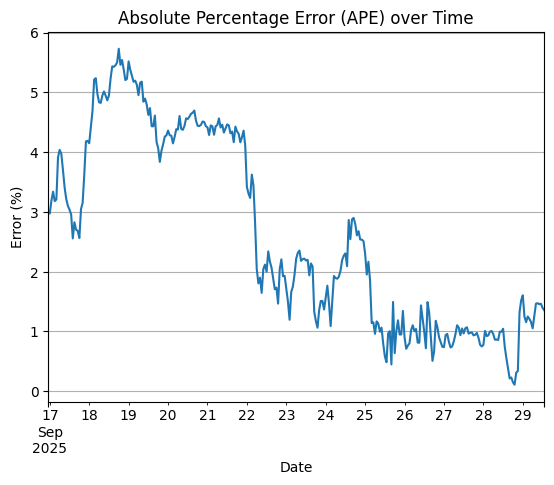

In [22]:
# --- Detailed Error Analysis ---

# Consolidate results into a structured DataFrame for point-wise analysis
r = pd.DataFrame({
    'Date': future_index,
    'Real values': y_true_wf,
    'Predictions': predictions_wf
})
r.set_index('Date', inplace=True)

# Calculate the Absolute Error (AE) for each step
# Formula: $AE = |y_{true} - y_{pred}|$
r['AE'] = abs(r['Real values'] - r['Predictions'])

# Calculate the Absolute Percentage Error (APE) for each step
# Formula: $APE = |\frac{y_{true} - y_{pred}}{y_{true}}| \times 100$
r['APE'] = (
    abs(r['AE'] / r['Real values']) 
    * 100
)

# Visualize the error trend over the prediction horizon
# Using the default backend (Matplotlib) for a quick diagnostic plot
r['APE'].plot(
    title='Absolute Percentage Error (APE) over Time',
    ylabel='Error (%)',
    xlabel='Date',
    grid=True,
)

## 4- Expérimentation

À ce stade de la démarche, tous les outils nécessaires ont été mis en place : le pipeline de préparation des données, l’architecture modulaire du modèle, la stratégie d’évaluation (*walk-forward*), ainsi que les métriques pertinentes. Il ne reste plus qu’à lancer l’expérimentation.

Puisqu’il s’agit d’une optimisation systématique de modèles, il est essentiel de définir précisément quels hyperparamètres seront explorés et pourquoi. Les choix retenus visent à couvrir les dimensions critiques de la modélisation temporelle dans un contexte de marché bruité comme celui des cryptomonnaies :

- *Input_width* : Définit la mémoire temporelle du modèle, c’est-à-dire le nombre de pas passés utilisés pour prédire le futur. Une fenêtre trop courte prive le modèle de contexte nécessaire (ex. tendance, cycle), une fenêtre trop longue introduit du bruit ancien ou des régimes de marché obsolètes, ce qui nuit à la généralisation.

- *Batch_size* : Correspond à la taille des mini-lots utilisés lors de la descente de gradient. C’est un compromis entre stabilité et exploration : des lots plus petits introduisent du bruit dans les mises à jour, ce qui peut aider à échapper aux minima locaux, mais augmente le coût computationnel et la variance de l’apprentissage. Des lots plus grands offrent des gradients plus stables, au risque de converger vers des solutions sous-optimales.

- *Learning_rate* : C’est le pas de mise à jour des poids à chaque itération. Il contrôle à la fois la vitesse de convergence et la qualité du minimum atteint. Un taux trop faible ralentit l’apprentissage ; un taux trop élevé provoque des oscillations ou une divergence, car les mises à jour « dépassent » les zones optimales.

- *Model_units* : Définit la richesse des représentations internes du modèle. Trop peu d’unités entraînent un sous-apprentissage (le modèle ne peut pas capturer les dynamiques temporelles complexes) ; trop d’unités favorisent le surapprentissage, surtout sur des données bruitées comme les prix de cryptomonnaies, où le modèle mémorise le hasard plutôt qu’un signal véritable.

- *Drop_out* : Mécanisme de régularisation qui désactive aléatoirement une fraction des neurones pendant l’entraînement. Cela force le réseau à ne pas dépendre de chemins spécifiques et à distribuer l’information, ce qui limite fortement le surapprentissage. Un taux trop élevé peut toutefois empêcher l’apprentissage utile (sous-apprentissage).

- *Number_of_layer* : Profondeur du réseau. Plus il y a de couches, plus le modèle peut extraire des motifs temporels hiérarchiques (ex. : variations locales → tendances → régimes). Cependant, dans les architectures récurrentes, une profondeur excessive aggrave les problèmes de gradients (disparition ou explosion), surtout sur des séquences longues, rendant l’entraînement instable ou inefficace.

- *loss_function* : La fonction de perte définit ce que le modèle cherche à minimiser, donc ce qu’il considère comme une « bonne » prédiction :

    - *MSE* pénalise fortement les grandes erreurs, ce qui la rend sensible aux outliers.

    - *MAE* traite toutes les erreurs de façon linéaire, offrant plus de robustesse, mais moins de sensibilité aux écarts extrêmes.

    - *Huber* combine les deux : robuste aux outliers, tout en restant sensible aux petites erreurs.

L’exploration de ces hyperparamètres, combinée à l’étude de trois architectures de réseaux de neurones différentes (LSTM, GRU et SimpleRNN), conduit à un nombre élevé d’expériences, environ une centaine, même en se limitant à des variations univariées (c’est-à-dire en faisant varier un seul hyperparamètre à la fois).  

Dans ce contexte, la traçabilité manuelle devient rapidement impraticable. Pourtant, elle est indispensable : sans un suivi rigoureux, il est impossible de reproduire les résultats, de comparer objectivement les performances ou d’identifier les facteurs réellement influents sur la qualité des prédictions.

C’est pourquoi MLflow a été intégré au pipeline expérimental. Cet outil permet d’enregistrer automatiquement, pour chaque exécution :

- Les hyperparamètres utilisés,

- Les métriques d’évaluation (MAE, RMSE, pertes d’entraînement, etc.),

- Les artefacts produits (modèles sauvegardés, figures de prédictions, courbes d’apprentissage).

A cela se rajoute un script qui permet d’afficher les différentes courbes pour analyser les résultats.

In [ ]:
# MLflow Hyperparameter Sweep - Normal Price Values.

# --- Configuration & Search Space ---
date = datetime.datetime.now().strftime("%Y_%m_%d")
model_list = ["lstm", "gru", "simplernn"]

search_space = {
    "input_width": [12, 24, 48, 72, 96],
    "batch_size": [16, 32, 64, 128],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1],
    "model_units": [10, 50, 100, 200],
    "dropout_rate": [0, 0.2, 0.5, 0.8],
    "number_of_layer": [1, 2, 3, 4],
    "loss_function": ['mae', 'mse', 'huber'],
}

base_config = {
    "input_width": 24,
    "batch_size": 32,
    "epochs": 50,
    "learning_rate": 0.001,
    "model_units": 50,
    "dense_units": 1,
    "dropout_rate": 0.2,
    "number_of_layer": 1,
    "loss_function": 'mae',
    "train_ratio": 0.7,
    "val_ratio": 0.25,
    'optimizer_name': 'adam',
}

# --- Experiment Loop ---

for model_type in model_list:
    for param_name, values in search_space.items():
        # Set experiment scope per model/parameter combination
        experiment_name = f"{model_type}_{param_name}_{date}"
        mlflow.set_experiment(experiment_name)

        for value in values:
            print(f"--- Model: {model_type} | Param: {param_name} = {value} ---")
            
            # Memoriy cleanup and seed reset for reproducibility
            tf.keras.backend.clear_session()
            set_seed(42)
            
            # Generate configuration for this specific run         
            run_config = base_config.copy() 
            run_config[param_name] = value
            run_name = f"{param_name}_{value}"

            with mlflow.start_run(run_name=run_name):
                # 1. Logging Metadata 
                mlflow.log_params(run_config)
                mlflow.log_param("model_name", model_type)
                mlflow.log_param("studied_parameter", param_name)

                # 2. Data Preparation
                df_raw = pd.read_csv('../data/dataset/BTCUSDT_1h.csv')
                df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'], unit='ms')
                df_raw.set_index('timestamp', inplace=True)
                
                # Filter for 2025 data (Normal values, no log-transform)
                df_2025= df_raw[df_raw.index.year == 2025][['close']].sort_index()

                df_train, df_val, df_test, train_gen, val_gen, test_gen, scaler = (
                    split_and_generate_dataset(
                        df_2025,
                        input_width=run_config['input_width'],
                        batch_size=run_config['batch_size'],
                    )
                )
                
                # 3. Model Architecture Construction
                input_shape = (run_config['input_width'], 1)
                layer_config = []
                
                for i in range(run_config['number_of_layer']):
                    layer_config.append({
                        'type' : model_type,
                        'units': run_config['model_units'],
                        'return_sequences': True if i < run_config['number_of_layer'] - 1 else False
                    })
                    layer_config.append({
                        'type' : 'dropout',
                        'rate': run_config['dropout_rate']
                    })
                
                layer_config.append({
                    'type' : 'dense',
                    'units': run_config['dense_units']
                    })
                    
                mg = ModelGenerator(input_shape=input_shape)
                model = mg.build_model(
                    layers_config=layer_config,
                    optimizer_name=run_config['optimizer_name'],
                    optimizer_config={'learning_rate': run_config['learning_rate']},
                    loss=run_config['loss_function'],
                    metrics=['mae', RootMeanSquaredError()]
                )
                
                # 4. Training with Early Stopping
                early_stop = EarlyStopping(
                    monitor='val_loss',
                    patience=20,
                    restore_best_weights=True
                    )
                history = mg.train(
                    train_gen,
                    val_gen,
                    epochs=run_config['epochs'],
                    callbacks=[early_stop]
                    )

                # 5. Log Training Metrics
                mlflow.log_metrics({
                    "final_train_loss": history.history['loss'][-1],
                    "final_val_loss": history.history['val_loss'][-1],
                    "final_val_mae": history.history['val_mae'][-1],
                    "final_val_rmse": history.history['val_root_mean_squared_error'][-1],
                })


                mlflow.keras.log_model(mg.model, name="model")
                mlflow.sklearn.log_model(scaler, name="scaler")

                # 6. Walk-Forward Prediction & Plotting
                predictions_wf, y_true_wf, df_init, future_index = run_walkforward_prediction(
                    df_test=df_test,
                    model=mg.model,
                    scaler=scaler,
                    input_width=run_config['input_width']
                )

                if predictions_wf is not None:
                    # Data consolidation for visualization
                    plot_df = pd.DataFrame({
                        'Date': future_index,
                        'Real values': y_true_wf,
                        'Predictions': predictions_wf
                    }).melt(id_vars='Date', var_name='Type', value_name='Valeur')

                    initial_df = pd.DataFrame({
                        'Date': df_init.index,
                        'Valeur': df_init['close'].values, 
                        'Type': 'Initial sequence'
                    })

                    full_plot_df = pd.concat([initial_df, plot_df], ignore_index=True)
                    
                    # Export data and log artifacts
                    dir_path = f"data/{date}/normal_value/{model_type}"
                    os.makedirs(dir_path, exist_ok=True)
                    full_plot_df.to_csv(f"{dir_path}/{run_name}.csv", index=False)

                    mlflow.log_table(data=full_plot_df, artifact_file="predictions_table.json")
                    
                    fig2 = px.line(
                        full_plot_df, x='Date', y='Valeur', color='Type',
                        title=f'WF Pred: {model_type.upper()} | {param_name}={value}',
                        template='simple_white', color_discrete_map=custom_colors
                    )

                    plot_path = f"plot_{model_type}_{run_name}.html"
                    plot(fig2, filename=plot_path, auto_open=False)
                    mlflow.log_artifact(plot_path)
                    if os.path.exists(plot_path): os.remove(plot_path)

print("MLflow grid search cycle complete.")

## 5- Log-return
Une fois la première série d’expériences lancée, le constat est sans appel : les résultats sont insatisfaisants. Si une dégradation de la performance était attendue avec l’augmentation de l’horizon temporel, l'incapacité des modèles à capturer la dynamique immédiate des prix réels est flagrante : 

- **LSTM** : On observe une convergence systématique. Le modèle semble "abandonner" la capture de la volatilité au profit d’une convergence vers une moyenne stable, un comportement typique face à un signal non stationnaire.
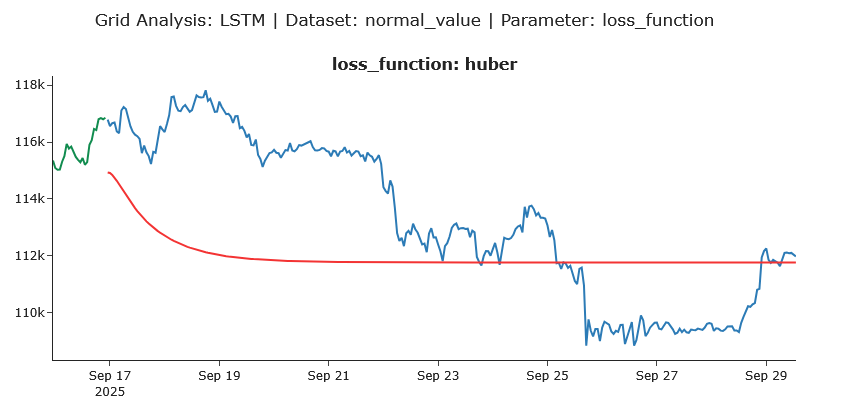

- **GRU** : Les comportements sont similaires pour une moitié, l’autre adoptant un caractère oscillatoire qui peut donner l’impression que le modèle parvient à capter quelque chose. Mais en se penchant sur les courbes on remarque qu’il s’agit de la séquence initiale répétée.
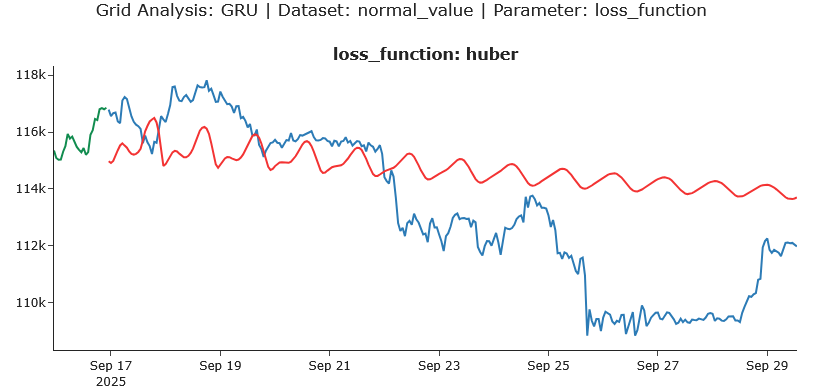

- **SimpleRNN** : C'est ici que l'on trouve la plus grande diversité de comportements, sans pour autant obtenir de résultats probants. Les courbes sont en majorité oscillatoire comme celle vue en GRU, ou bien adoptent des trajectoires "ésotériques" qui ne représente aucune réalité.
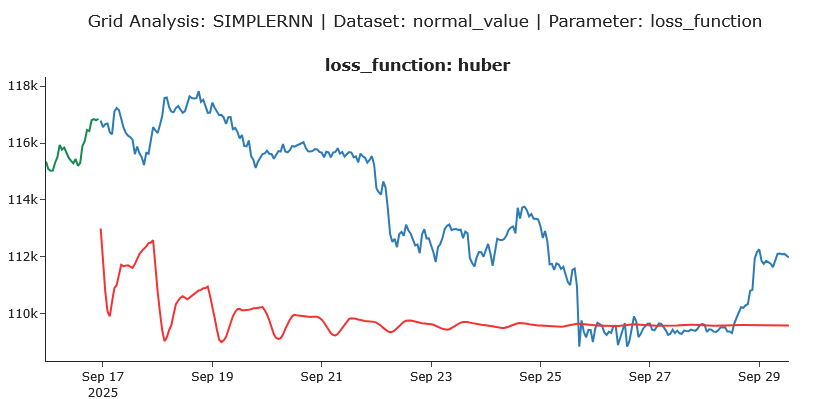
 
Cette tendance suggère que le signal temporel utile est peut-être noyé dans la non-stationnarité des prix bruts. En effet, les séries de prix de cryptomonnaies présentent :

- Une tendance forte et changeante (bull/bear markets),

- Une volatilité hétérogène (calme prolongé suivi de fortes variations),

- Une absence de moyenne stable.

Or, les réseaux récurrents, bien qu’ils possèdent une mémoire temporelle, supposent implicitement que les statistiques locales (moyenne, variance, autocorrélation) restent relativement constantes au cours du temps. Quand ce n’est pas le cas, le modèle apprend à minimiser l’erreur en « moyennant » les régimes passés, ce qui produit exactement les courbes plates ou oscillantes que nous observons.
Pour contourner ce problème, une pratique standard en finance consiste à transformer les prix en rendements, c’est-à-dire à se concentrer sur les variations relatives plutôt que sur les niveaux absolus. Parmi les formulations possibles, nous retenons le log-return :

$$l_t = \log \left( \frac{P_t}{P_{t-1}} \right)$$

avec $l_t$​ : Log-rendement à l'instant t.

$P_t$​ : Prix de close actuel.

$P_{t−1}$ : Prix de close de la bougie précédente.

Cette transformation est motivée par trois propriétés essentielles :

- Stationnarité améliorée : Ils offrent une distribution plus stable (moyenne proche de zéro et variance finie), ce qui facilite grandement la convergence des gradients.
- Additivité temporelle : Le rendement total sur périodes devient la simple somme des log-rendements de chaque période, simplifiant la manipulation mathématique par rapport aux rendements simples.
- Symétrie mathématique : contrairement aux rendements simples, les log-returns traitent les hausses et baisses de façon équilibrée (une hausse de +x suivie d’une baisse de –x ramène exactement au point de départ).
Malgré cette transformation les résultats, restent insatisfaisants :

- Les modèles LSTM persistent à produire des droites centrée sur zéro.
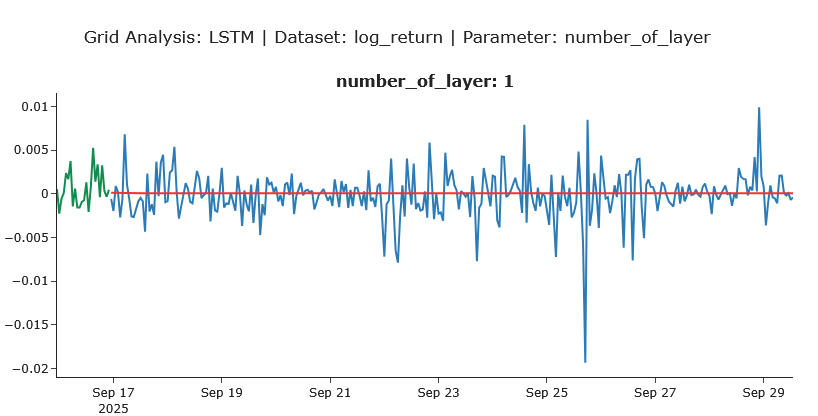
 
- Les GRU et SimpleRNN continuent de générer des motifs basé sur la séquence initiale, oscillant autour d’une moyenne.
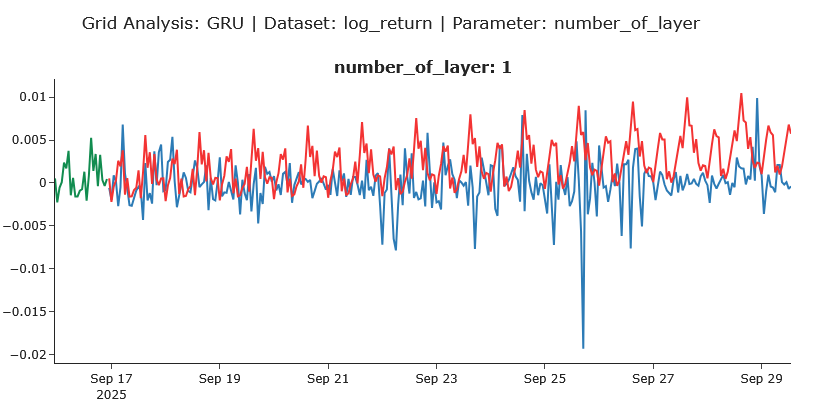

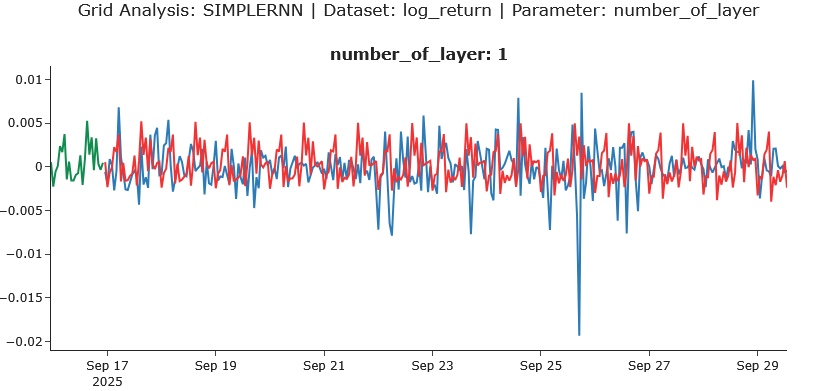

En conclusion, même après stationnarisation, aucun modèle ne parvient à capturer une dynamique prédictive exploitable. Ce résultat démontre que l'approche univariée, limitée aux seuls prix passés, est insuffisante pour extraire un signal prédictif exploitable sur le BTC/USDT. Le modèle se contente d’apprendre une tendance de fond ou une moyenne, ce qui confirme que la complexité du marché ne peut être capturée par une approche univariée : d’autres variables ou une architecture fondamentalement différente sont nécessaires.

Cette question sera approfondie dans l’article 5, qui posera les jalons pour la suite des actions.




In [ ]:
# Log-Return Grid Search Experimentation Script.
# --- Configuration & Search Space ---

date = datetime.datetime.now().strftime("%Y_%m_%d")
model_list = ["lstm", "gru", "simplernn"]

search_space = {
    "input_width": [12, 24, 48, 72, 96],
    "batch_size": [16, 32, 64, 128],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1],
    "model_units": [10, 50, 100, 200],
    "dropout_rate": [0, 0.2, 0.5, 0.8],
    "number_of_layer": [1, 2, 3, 4],
    "loss_function": ['mae', 'mse', 'huber'],
}

base_config = {
    "input_width": 24,
    "batch_size": 32,
    "epochs": 50,
    "learning_rate": 0.001,
    "model_units": 50,
    "dense_units": 1,
    "dropout_rate": 0.2,
    "number_of_layer": 1,
    "loss_function": 'mae',
    "train_ratio": 0.7,
    "val_ratio": 0.25,
    'optimizer_name': 'adam',
}

# --- Experiment Loop ---

for model_type in model_list:
    for param_name, values in search_space.items():
        # Set experiment scope per model/parameter combination
        experiment_name = f"log_return_{model_type}_{param_name}_{date}"
        mlflow.set_experiment(experiment_name)

        for value in values:
            print(f"--- Model: {model_type} | Param: {param_name} = {value} ---")
            
            # Memoriy cleanup and seed reset for reproducibility
            tf.keras.backend.clear_session()
            set_seed(42)
            
            # Generate configuration for this specific run         
            run_config = base_config.copy() 
            run_config[param_name] = value
            run_name = f"{param_name}_{value}"

            with mlflow.start_run(run_name=run_name):
                # 1. Logging Metadata
                mlflow.log_params(run_config)
                mlflow.log_param("model_name", model_type)
                mlflow.log_param("studied_parameter", param_name)

                # 2. Data Preparation
                df_raw = pd.read_csv('../data/dataset/BTCUSDT_1h.csv')
                df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'], unit='ms')
                df_raw.set_index('timestamp', inplace=True)
                df_2025= df_raw[df_raw.index.year == 2025][['close']].sort_index()
                
                # Filter and transform to Log Returns (Stationarity)
                df_2025['close'] = np.log(df['close']).diff()
                df_2025 = df_2025.dropna()

                df_train, df_val, df_test, train_gen, val_gen, test_gen, scaler = (
                    split_and_generate_dataset(
                        df_2025,
                        input_width=run_config['input_width'],
                        batch_size=run_config['batch_size'],
                    )
                )
                
                # 3. Model Architecture Construction
                input_shape = (run_config['input_width'], 1)
                layer_config = []
                
                for i in range(run_config['number_of_layer']):
                    layer_config.append({
                        'type' : model_type,
                        'units': run_config['model_units'],
                        'return_sequences': True if i < run_config['number_of_layer'] - 1 else False
                    })
                    layer_config.append({
                        'type' : 'dropout',
                        'rate': run_config['dropout_rate']
                    })
                
                layer_config.append({
                    'type' : 'dense',
                    'units': run_config['dense_units']
                    })
                    
                mg = ModelGenerator(input_shape=input_shape)
                model = mg.build_model(
                    layers_config=layer_config,
                    optimizer_name=run_config['optimizer_name'],
                    optimizer_config={'learning_rate': run_config['learning_rate']},
                    loss=run_config['loss_function'],
                    metrics=['mae', RootMeanSquaredError()]
                )
                
                # 4. Training with Early Stopping
                early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                history = mg.train(train_gen, val_gen, epochs=run_config['epochs'], callbacks=[early_stop])

                # 5. Log Training Metrics
                mlflow.log_metrics({
                    "final_train_loss": history.history['loss'][-1],
                    "final_val_loss": history.history['val_loss'][-1],
                    "final_val_mae": history.history['val_mae'][-1],
                    "final_val_rmse": history.history['val_root_mean_squared_error'][-1],
                })

                mlflow.keras.log_model(mg.model, name="model")
                mlflow.sklearn.log_model(scaler, name="scaler")

                # 6. Walk-Forward Prediction & Plotting
                predictions_wf, y_true_wf, df_init, future_index = run_walkforward_prediction(
                    df_test=df_test,
                    model=mg.model,
                    scaler=scaler,
                    input_width=run_config['input_width']
                )

                if predictions_wf is not None:
                    # Data consolidation for visualization
                    plot_df = pd.DataFrame({
                        'Date': future_index,
                        'Real values': y_true_wf,
                        'Predictions': predictions_wf
                    }).melt(id_vars='Date', var_name='Type', value_name='Valeur')

                    initial_df = pd.DataFrame({
                        'Date': df_init.index,
                        'Valeur': df_init['close'].values, 
                        'Type': 'Initial sequence'
                    })

                    full_plot_df = pd.concat([initial_df, plot_df], ignore_index=True)
                    
                    # Export data and log artifacts
                    dir_path = f"data/{date}/log_return/{model_type}"
                    os.makedirs(dir_path, exist_ok=True)
                    full_plot_df.to_csv(f"{dir_path}/{run_name}.csv", index=False)
                    
                    fig2 = px.line(
                        full_plot_df, x='Date', y='Valeur', color='Type',
                        title=f'WF Pred: {model_type.upper()} | {param_name}={value}',
                        template='simple_white', color_discrete_map=custom_colors
                    )

                    plot_path = f"plot_{model_type}_{run_name}.html"
                    plot(fig2, filename=plot_path, auto_open=False)
                    mlflow.log_artifact(plot_path)
                    if os.path.exists(plot_path): os.remove(plot_path)

print("MLflow grid search cycle complete.")

In [17]:
"""
Crypto Predictor Analysis Dashboard.

This Dash app aggregates results from the MLflow-driven experiments,
allowing for side-by-side comparison of different hyperparameters and 
model architectures across Log-Return and Normal Value datasets.
"""

# --- 1. Data Aggregation ---

date = "2026_01_15" # or datetime.datetime.now().strftime("%Y_%m_%d") 
base_path = os.path.join("..", "data", date)
all_results = []

# Walk through the directory structure to collect experiment CSVs
for data_type in ['normal_value', 'log_return']:
    for model_name in ['lstm', 'gru', 'simplernn']:
        folder_path = os.path.join(base_path, data_type, model_name)
        
        if not os.path.exists(folder_path):
            continue
            
        for file in os.listdir(folder_path):
            if not file.endswith('.csv'):
                continue
                
            csv_path = os.path.join(folder_path, file)
            df = pd.read_csv(csv_path)
            
            # Enrich the dataframe with metadata extracted from path/filename
            df['analysis_type'] = data_type
            df['model_name'] = model_name
            
            # Split 'param_value' from filename (e.g., 'learning_rate_0.01.csv')
            param_string = file.replace('.csv', '')
            try:
                name, val = param_string.rsplit('_', 1)
                df['param_name'] = name
                df['param_value'] = val
            except ValueError:
                continue
                
            all_results.append(df)

# Combine all experiment data into a single master DataFrame
if all_results:
    df_results = pd.concat(all_results, ignore_index=True)
else:
    print("Warning: No results found in the specified path.")
    df_results = pd.DataFrame()

# --- 2. Dash Application Layout ---

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Crypto Predictor Analysis Dashboard", style={'textAlign': 'center', 'padding': '20px'}),
    
    # Navigation & Filter Bar
    html.Div([
        html.Div([
            html.Label("Analysis Type", style={'fontWeight': 'bold'}),
            dcc.Dropdown(
                id='dropdown-analysis', 
                options=[{'label': i.replace('_', ' ').title(), 'value': i} 
                         for i in sorted(df_results['analysis_type'].unique())],
                value=df_results['analysis_type'].unique()[0] if not df_results.empty else None
            )
        ], style={'width': '30%', 'display': 'inline-block'}),
        
        html.Div([
            html.Label("Model Architecture", style={'fontWeight': 'bold'}),
            dcc.Dropdown(
                id='dropdown-model', 
                options=[{'label': i.upper(), 'value': i} 
                         for i in sorted(df_results['model_name'].unique())],
                value=df_results['model_name'].unique()[0] if not df_results.empty else None
            )
        ], style={'width': '30%', 'display': 'inline-block', 'marginLeft': '5%'}),
        
        html.Div([
            html.Label("Hyperparameter Tested", style={'fontWeight': 'bold'}),
            dcc.Dropdown(id='dropdown-param')
        ], style={'width': '30%', 'display': 'inline-block', 'marginLeft': '5%'})
    ], style={'padding': '20px', 'backgroundColor': '#f9f9f9', 'borderRadius': '10px', 'margin': '20px'}),

    # Primary Visualization Area
    dcc.Loading(
        id="loading-graph",
        type="circle",
        children=dcc.Graph(id='main-graph', style={'height': '85vh'})
    )
])

# --- 3. Callbacks ---

@app.callback(
    Output('dropdown-param', 'options'),
    Output('dropdown-param', 'value'),
    [DashInput('dropdown-analysis', 'value'),
     DashInput('dropdown-model', 'value')]
)
def update_param_list(analysis_type, model_name):
    """Updates the parameter list based on selected analysis type and model."""
    mask = (df_results['analysis_type'] == analysis_type) & (df_results['model_name'] == model_name)
    params = sorted(df_results[mask]['param_name'].unique())
    options = [{'label': p.replace('_', ' ').title(), 'value': p} for p in params]
    default_val = params[0] if params else None
    return options, default_val

@app.callback(
    Output('main-graph', 'figure'),
    [DashInput('dropdown-analysis', 'value'),
     DashInput('dropdown-model', 'value'),
     DashInput('dropdown-param', 'value')]
)
def update_graph(a_type, m_name, p_name):
    """Generates a grid of plots for each value tested within a parameter group."""
    if not p_name: 
        return go.Figure()

    # Filter data for specific grid view
    sub_df = df_results[
        (df_results['analysis_type'] == a_type) & 
        (df_results['model_name'] == m_name) & 
        (df_results['param_name'] == p_name)
    ]
    
    # Sort parameter values numerically if possible
    p_values = sorted(
        sub_df['param_value'].unique(), 
        key=lambda x: (float(x) if str(x).replace('.', '', 1).isdigit() else x)
    )
    
    cols = 2
    rows = int(np.ceil(len(p_values) / cols))
    
    fig = make_subplots(
        rows=rows, cols=cols,
        subplot_titles=[f"<b>{p_name}: {v}</b>" for v in p_values],
        vertical_spacing=0.1, 
        horizontal_spacing=0.08
    )

    for i, val in enumerate(p_values):
        v_df = sub_df[sub_df['param_value'] == val]
        r, c = (i // cols) + 1, (i % cols) + 1
        
        for t_type in ['Initial sequence', 'Real values', 'Predictions']:
            t_data = v_df[v_df['Type'] == t_type]
            fig.add_trace(go.Scatter(
                x=t_data['Date'], 
                y=t_data['Valeur'],
                name=t_type, 
                line=dict(color=custom_colors[t_type]),
                legendgroup=t_type,
                showlegend=(i == 0)
            ), row=r, col=c)

    fig.update_layout(
        template='simple_white',
        margin=dict(t=100, b=50, l=50, r=50),
        hovermode='x unified',
        title=f"Grid Analysis: {m_name.upper()} | Dataset: {a_type} | Parameter: {p_name}"
    )
    
    return fig

if __name__ == '__main__':
    app.run(debug=True, port=8050)
    #The page can be accessed at http://127.0.0.1:8050/
    
    